# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: CodeChallenge: Gaussians with fewer layers
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the data

In [3]:
nImages = 3000
imgSize = 64

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)

for i in range(nImages):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  width = np.random.rand()/.6 + 1.8 # random width
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

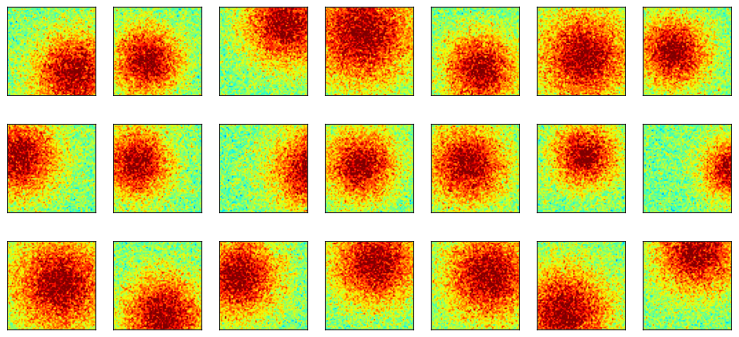

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create classes for the discriminator and generator

In [5]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [6]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  1, 64, 4, 3, 0, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 3, 0, bias=False)
    self.conv3 = nn.Conv2d(128,  1, 4, 3, 0, bias=False)
    # self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    # self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    # self.bn3 = nn.BatchNorm2d(256)
    # self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    # x = F.leaky_relu( self.conv3(x) ,.2)
    # x = self.bn3(x)
    # x = F.leaky_relu( self.conv4(x) ,.2)
    # x = self.bn4(x)
    return torch.sigmoid( self.conv3(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


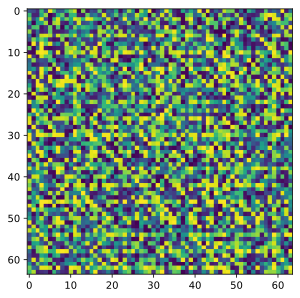

In [7]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,256, 4, 4, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(256,128, 4, 4, 0, bias=False)
    self.conv3 = nn.ConvTranspose2d(128,  1, 4, 4, 0, bias=False)
    # self.conv4 = nn.ConvTranspose2d( 64,  1, 4, 2, 0, bias=False)
    # self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(256)
    self.bn2 = nn.BatchNorm2d(128)
    # self.bn3 = nn.BatchNorm2d( 64)
    # self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    # x = F.relu( self.bn3(self.conv3(x)) )
    # x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv3(x) )
    return x


gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

# Train the models!

In [18]:
# training parameters and initializations
num_epochs = 10500
batchsize  = 86
losses     = []
disDecs    = [] # disDecs = discriminator decisions


for epochi in range(num_epochs):

  # create a minibatch from randomly selected images
  ridx = torch.randint(images.shape[0],(batchsize,))
  data = images[ridx,:].to(device)


  # create labels for real and fake images
  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = dnet(data)                     # output of discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

  # forward pass and loss for FAKE pictures
  fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
  fake_images = gnet(fake_data)                           # output of generator
  pred_fake   = dnet(fake_images)                         # pass through discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()



  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
  pred_fake   = dnet(fake_images)

  # compute loss
  g_loss = lossfun(pred_fake,real_labels)

  # backprop
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()


  # collect losses and discriminator decisions
  losses.append([d_loss.item(),g_loss.item()])

  d1 = torch.mean((pred_real>.5).float()).detach()
  d2 = torch.mean((pred_fake>.5).float()).detach()
  disDecs.append([d1,d2])


  # print out a status message
  if (epochi+1)%50==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)




Finished epoch 10500/10500

In [19]:
# convert performance from list to numpy array
losses  = np.array(torch.tensor(losses).cpu())
disDecs = np.array(torch.tensor(disDecs).cpu())

In [20]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [21]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

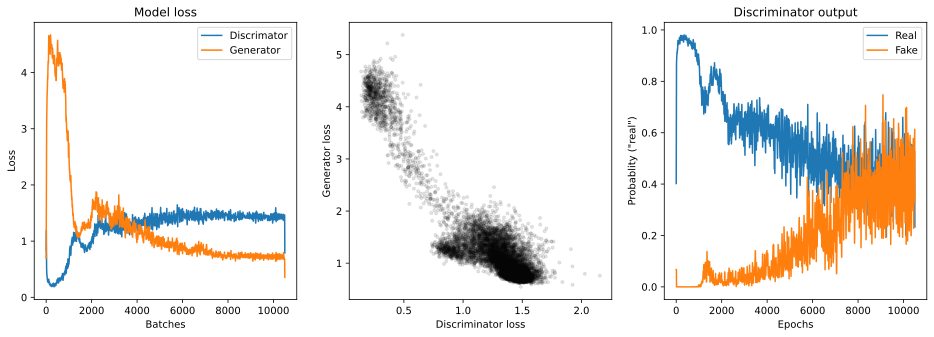

In [22]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])

ax[1].plot(losses[:,0],losses[:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Let's see some generated Gaussians!

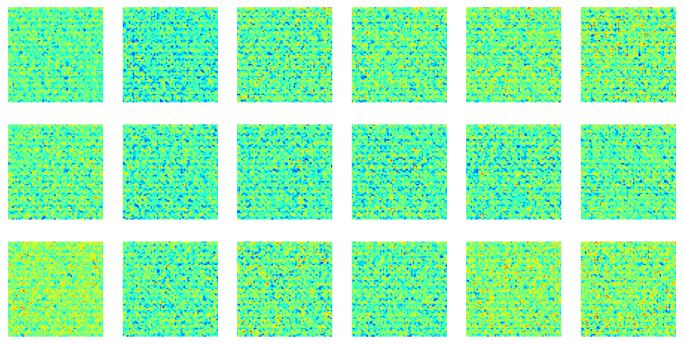

In [23]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()